# Initial Setup

In [1]:
import os
import numpy as np
import datetime
import time
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.util.tf_export import keras_export

from utils.resnet import ResNet

print(tf.__version__)

2.2.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Imagenet Subset 

In [3]:
dataDir = '/data/datasets/cifar100/raw'

configDir = 'config'
resultsDir = 'results'
modelsDir = 'models/cifar100_resnet50_adam_v6'
logsDir = 'logs/cifar100_resnet50_adam_v6'

In [4]:
BATCH_SIZE = 128
NUM_EPOCHS = 200
AUTOTUNE = tf.data.experimental.AUTOTUNE

NUM_CLASSES = 100
IMG_HEIGHT = 32
IMG_WIDTH = 32
NUM_CHANNELS = 3
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

In [5]:
if not os.path.exists(configDir):
  os.makedirs(configDir)

if not os.path.exists(resultsDir):
  os.makedirs(resultsDir)

if not os.path.exists(modelsDir):
  os.makedirs(modelsDir)
        
if not os.path.exists(logsDir):
  os.makedirs(logsDir)

In [6]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [7]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')


In [8]:
def rotate_zoom_tf(image, angle, zoom):

  angleRad = angle/180.*np.pi

  if image.shape.__len__() ==4:
    random_angles = tf.random.uniform(shape = (tf.shape(image)[0], ), minval = -angleRad, maxval = angleRad)
    random_zoom = tf.random.uniform(shape = (tf.shape(image)[0], ), minval = 1-zoom, maxval = 1+zoom)
  if image.shape.__len__() ==3:
    random_angles = tf.random.uniform(shape = (), minval = -angleRad, maxval = angleRad)
    random_zoom = tf.random.uniform(shape = (), minval = 1-zoom, maxval = 1+zoom)

  paddings = tf.constant([[int(IMG_HEIGHT/4), int(IMG_HEIGHT/4)], [int(IMG_WIDTH/4), int(IMG_WIDTH/4)], [0,0]])
  img = tf.pad(image, paddings, "SYMMETRIC")
  img = tfa.image.rotate(img, random_angles)
  img = tf.image.resize_with_crop_or_pad(img, int(IMG_HEIGHT*random_zoom), int(IMG_WIDTH*random_zoom))
  img = tf.image.resize(img, [IMG_HEIGHT,IMG_WIDTH], method=tf.image.ResizeMethod.BILINEAR)

  #tf.print(random_angles)
  #tf.print(random_zoom)
  return img

def rotate_tf(image, angle):
  angleRad = angle/180.*np.pi

  if image.shape.__len__() ==4:   
    random_angles = tf.random.uniform(shape = (tf.shape(image)[0], ), minval = -angleRad, maxval = angleRad)
  if image.shape.__len__() ==3:
    random_angles = tf.random.uniform(shape = (), minval = -angleRad, maxval = angleRad)

  paddings = tf.constant([[int(IMG_HEIGHT/4), int(IMG_HEIGHT/4)], [int(IMG_WIDTH/4), int(IMG_WIDTH/4)], [0,0]])
  img = tf.pad(image, paddings, "SYMMETRIC")
  img = tfa.image.rotate(img, random_angles)
  img = tf.image.resize_with_crop_or_pad(img, IMG_HEIGHT, IMG_WIDTH)

  return img

def augment(image, label):
  #img = tf.image.rot90(image)
  img = tf.image.flip_left_right(image)
  #img = rotate_tf(image, 20)
  img = rotate_zoom_tf(image, 20, 0.2)
  #img = tf.image.random_brightness(img, 0.05)
  #img = tf.image.random_contrast(img, 0.9, 1.1)
  img = tf.clip_by_value(img, 0.0, 1.0)
  
  return (img, label)

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  #ds = ds.map(augment, num_parallel_calls=AUTOTUNE)

  # Repeat forever
  #ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

def prepare_for_validation(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [9]:
meta = unpickle(os.path.join(dataDir, 'meta'))
train = unpickle(os.path.join(dataDir, 'train'))
test = unpickle(os.path.join(dataDir, 'test'))

In [10]:
classDF = pd.DataFrame(meta[b'fine_label_names'], columns = ['Classes'], dtype=str)
CLASS_NAMES = np.array(classDF['Classes'])

In [11]:
trainX = np.vstack(train[b"data"])
trainX = trainX.reshape(len(trainX), NUM_CHANNELS, IMG_HEIGHT, IMG_WIDTH).transpose(0,2,3,1).astype("float32")/255
trainY = train[b'fine_labels']
trainY = tf.one_hot(trainY, NUM_CLASSES)

testX = np.vstack(test[b"data"])
testX = testX.reshape(len(testX), NUM_CHANNELS, IMG_HEIGHT, IMG_WIDTH).transpose(0,2,3,1).astype("float32")/255
testY = test[b'fine_labels']
testY = tf.one_hot(testY, NUM_CLASSES)

In [12]:
print(trainX.shape)
print(testX.shape)

print(trainY.shape)
print(testY.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 100)
(10000, 100)


In [13]:
trainLabelDS = tf.data.Dataset.from_tensor_slices((trainX, trainY))
valLabelDS = tf.data.Dataset.from_tensor_slices((testX, testY))

In [14]:
trainDS = prepare_for_training(trainLabelDS)
valDS = prepare_for_validation(valLabelDS)

In [15]:
'''
for image, label in valDS.take(1):
  temp = image[0,:]
  print(temp.shape)
  plt.imshow(temp)
  plt.show()
  
  temp2 = rotate_zoom_tf(temp, 20, 0.2)
  plt.imshow(temp2)
  plt.show()

#plt.imshow(img_temp.numpy())
'''

'\nfor image, label in valDS.take(1):\n  temp = image[0,:]\n  print(temp.shape)\n  plt.imshow(temp)\n  plt.show()\n  \n  temp2 = rotate_zoom_tf(temp, 20, 0.2)\n  plt.imshow(temp2)\n  plt.show()\n\n#plt.imshow(img_temp.numpy())\n'

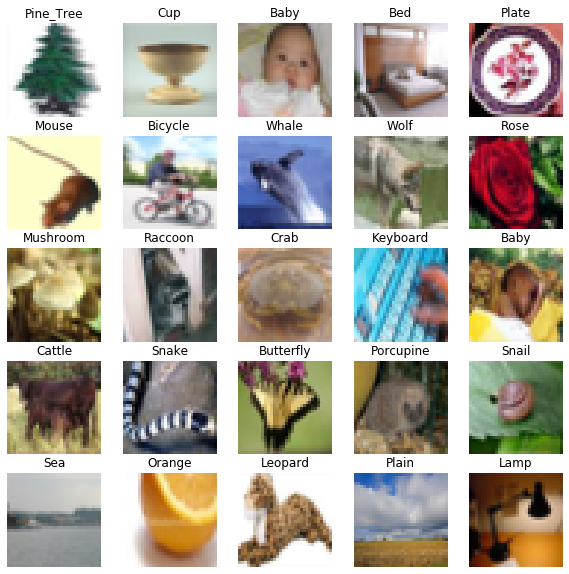

In [16]:
image_batch, label_batch = next(iter(trainDS))
show_batch(image_batch.numpy(), label_batch.numpy())

## Create model

In [17]:
modelDiagramFile = os.path.join(resultsDir, 'model_resnet50_cifar100.png')

model = ResNet.build(32, 32, NUM_CHANNELS, NUM_CLASSES, (9, 9, 9), (64, 64, 128, 256), reg=0.0005)


## Train model

In [18]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
        
    tf.summary.scalar('learning rate', data=lr, step=epoch)
    print('Learning rate: ', lr)
    return lr

In [19]:
logsCheckDir = os.path.join(logsDir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
file_writer = tf.summary.create_file_writer(logsCheckDir + "/metrics")
file_writer.set_as_default()

tb_callback = keras.callbacks.TensorBoard(log_dir=logsCheckDir, histogram_freq=1)
ck_callback = keras.callbacks.ModelCheckpoint(os.path.join(modelsDir, "model_checkpoint_{epoch}.h5"))
lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)

callbacks = [tb_callback, ck_callback, lr_callback]

optimizer = tf.optimizers.Adam(learning_rate=lr_schedule(0))

model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

Learning rate:  0.001


In [20]:
startTime = time.time()

model.fit(trainDS,
          epochs=NUM_EPOCHS,
          callbacks=callbacks,
          validation_data=valDS,
          validation_freq=1)

endTime = time.time()

elapsedTime = (endTime - startTime)/60.
print("\nTotal time for model training: {} minutes".format(elapsedTime))

Learning rate:  0.001
Epoch 1/200
391/391 [==============================] - 38s 96ms/step - loss: 4.3020 - accuracy: 0.1137 - val_loss: 3.9115 - val_accuracy: 0.1695 - lr: 0.0010
Learning rate:  0.001
Epoch 2/200
391/391 [==============================] - 35s 91ms/step - loss: 3.5680 - accuracy: 0.2309 - val_loss: 3.5033 - val_accuracy: 0.2418 - lr: 0.0010
Learning rate:  0.001
Epoch 3/200
391/391 [==============================] - 36s 91ms/step - loss: 3.1006 - accuracy: 0.3165 - val_loss: 3.0345 - val_accuracy: 0.3280 - lr: 0.0010
Learning rate:  0.001
Epoch 4/200
391/391 [==============================] - 35s 91ms/step - loss: 2.7632 - accuracy: 0.3896 - val_loss: 2.8640 - val_accuracy: 0.3678 - lr: 0.0010
Learning rate:  0.001
Epoch 5/200
391/391 [==============================] - 35s 91ms/step - loss: 2.5142 - accuracy: 0.4463 - val_loss: 2.6902 - val_accuracy: 0.4045 - lr: 0.0010
Learning rate:  0.001
Epoch 6/200
391/391 [==============================] - 35s 91ms/step - loss: 2

## Save model

In [21]:
modelFile = os.path.join(modelsDir, 'model_resnet50.h5')

model.save(modelFile)

## Plot confusion matrix

In [22]:
from sklearn.metrics import confusion_matrix

In [23]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(16,16))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    '''
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    '''
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [24]:
y_pred=np.argmax(model.predict(testX), axis=1)
y_true=np.argmax(testY, axis=1)

#Compute the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

Confusion matrix, without normalization


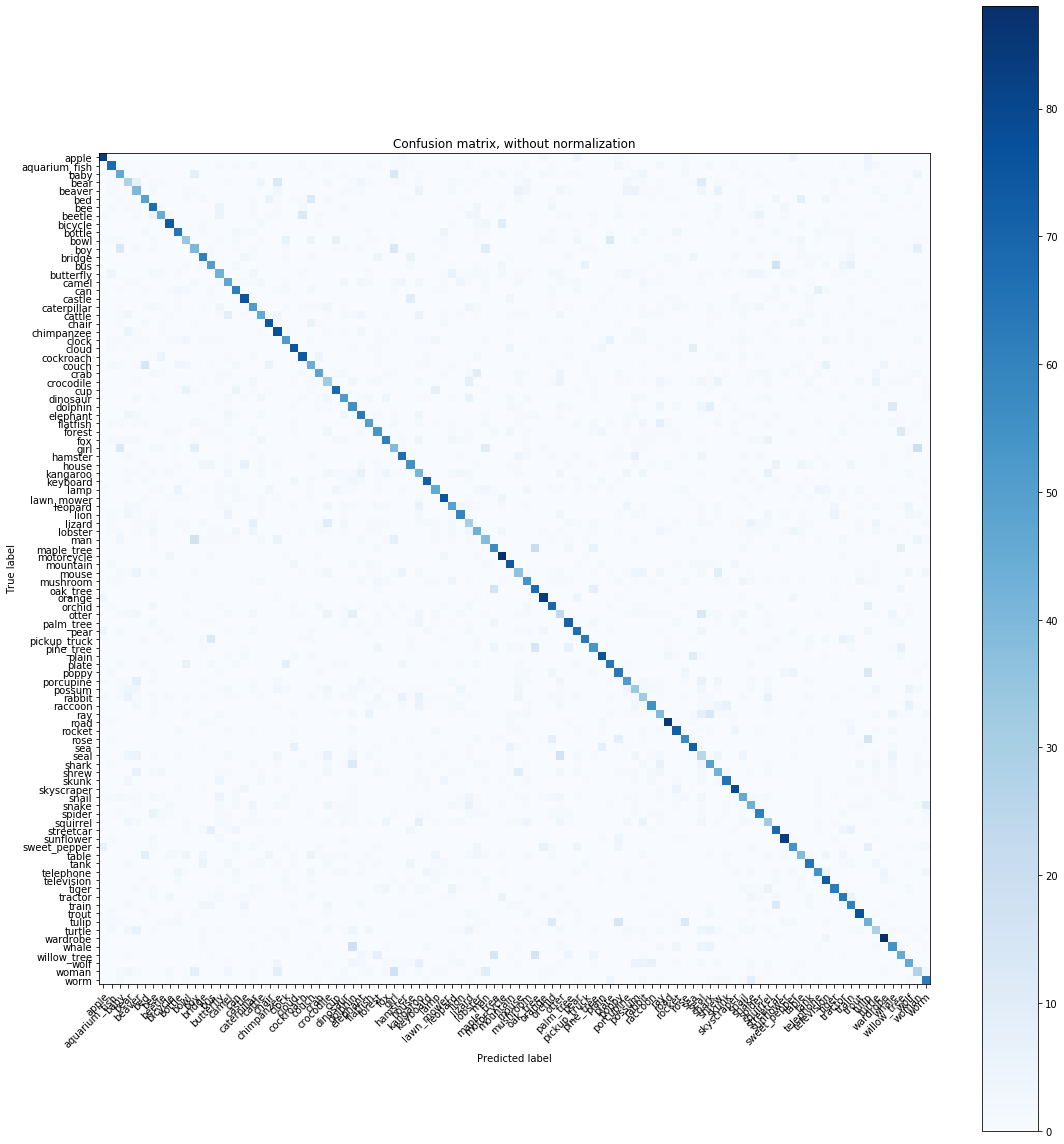

In [25]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=CLASS_NAMES,
                      title='Confusion matrix, without normalization')